# 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
# 공통 모듈 임포트
import numpy as np
import os
# 깔끔한 그래프 출력을 위해
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, 'binary')
    plt.axis('off')

## 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다:

In [3]:
def generate_3d_data(m, w1=.1, w2=.3, noise=.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - .5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * .7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(0)

오토인코더를 만든다.

In [4]:
encoder = keras.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(keras.optimizers.experimental.SGD(1.5), 'mse')

In [5]:
# history = autoencoder.fit(X_train, X_train, epochs=20)
history = autoencoder.fit(X_train, X_train, epochs=1)

2/2 [==============================] - 3s 7ms/step - loss: 0.5213


In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


그림 저장 linear_autoencoder_pca_plot


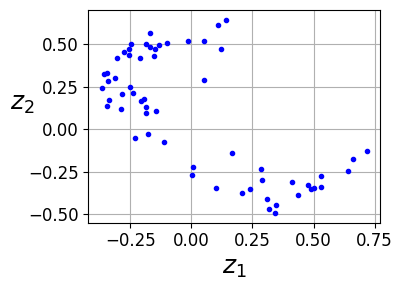

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## 적층 오토인코더

### 케라스를 사용하여 적층 오토인코더 구현하기

MNIST 데이터셋을 사용한다:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.math.round(y_true), tf.math.round(y_pred))

In [11]:
stacked_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'selu')]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))
history = stacked_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.3384 - rounded_accuracy: 0.8871 - val_loss: 0.3131 - val_rounded_accuracy: 0.9080


### 재구성 시각화

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리한다. 그런 다음 원본 이미지와 재구성 이미지를 그린다:

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 68ms/step
그림 저장 reconstruction_plot


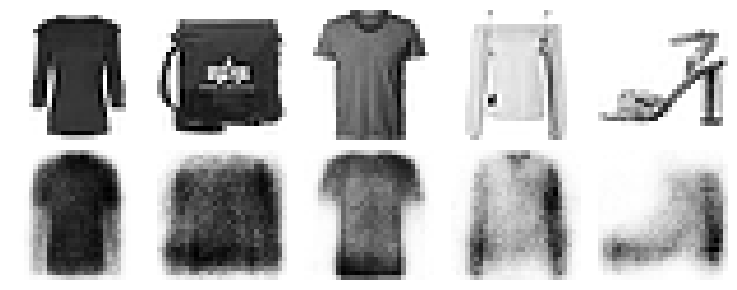

In [13]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

### 패션 MNIST 데이터셋 시각화

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 969us/step


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


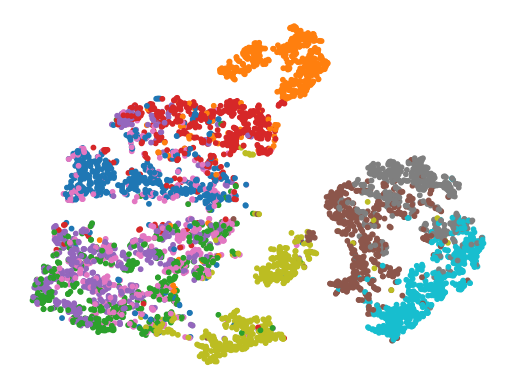

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap='tab10')
plt.axis('off')
plt.show()

이 그림을 조금 더 예쁘게 그린다:

그림 저장 fashion_mnist_visualization_plot


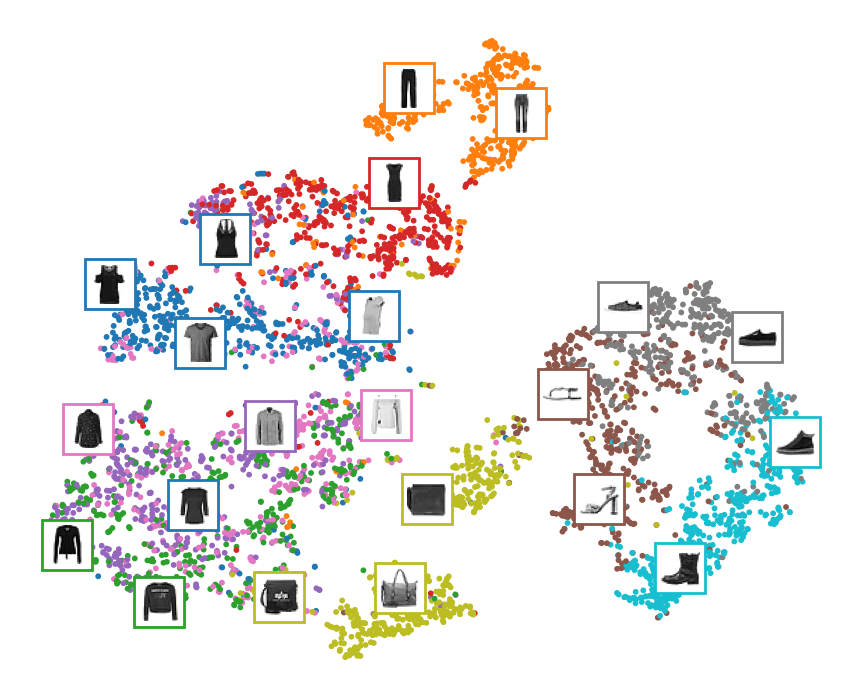

In [16]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, 1)
    if np.amin(dist) > .02:  # 다른 이미지에서 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position,
            bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')
plt.show()

### 가중치 묶기

인코더의 가중치를 전치(transpose)하여 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔하다. 이렇게 하려면 사용자 정의 층을 사용해야 한다.

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.biases = None
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight('bias', [self.dense.input_shape[-1]], initializer='zeros')
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, 'selu')
dense_2 = keras.layers.Dense(30, 'selu')
tied_encoder = keras.Sequential([keras.layers.Flatten(input_shape=[28, 28]), dense_1, dense_2])
tied_decoder = keras.Sequential(
    [DenseTranspose(dense_2, 'selu'), DenseTranspose(dense_1, 'sigmoid'), keras.layers.Reshape([28, 28])]
)
tied_ae = keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = tied_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.3288 - rounded_accuracy: 0.8943 - val_loss: 0.3066 - val_rounded_accuracy: 0.9102


1/1 [==============================] - 0s 67ms/step


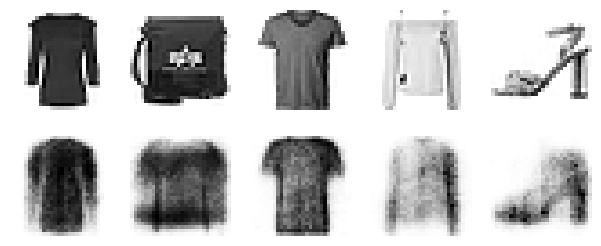

In [19]:
show_reconstructions(tied_ae)
plt.show()

### 한 번에 오토인코더 한 개씩 훈련하기

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.Sequential([keras.layers.Dense(n_neurons, 'selu', input_shape=[n_inputs])])
    decoder = keras.Sequential([keras.layers.Dense(n_inputs, output_activation)])
    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
flatten = keras.layers.Flatten()
X_train_flat = flatten(X_train)  # .reshape(-1, 28 * 28)과 동일
X_valid_flat = flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100,
    X_train_flat,
    X_valid_flat,
    'binary_crossentropy',
    keras.optimizers.experimental.SGD(1.5),
    # output_activation='sigmoid',
    # metrics=[rounded_accuracy]
    # 8,
    1,
    'sigmoid',
    [rounded_accuracy]
)
enc2, dec2, _, _ = train_autoencoder(
    # 30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.experimental.SGD(.05), output_activation='selu'
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.experimental.SGD(.05), 1, 'selu'
)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.1949 - val_loss: 0.0616


In [22]:
stacked_ae_1_by_1 = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), enc1, enc2, dec2, dec1, keras.layers.Reshape([28, 28])]
)

1/1 [==============================] - 0s 74ms/step


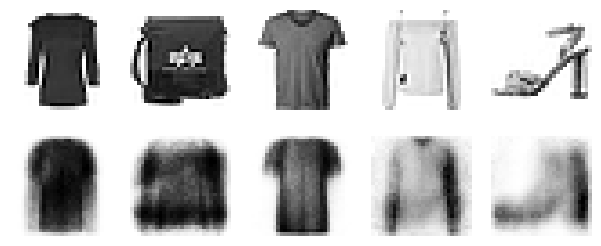

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = stacked_ae_1_by_1.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.3121 - rounded_accuracy: 0.9127 - val_loss: 0.3130 - val_rounded_accuracy: 0.9134


1/1 [==============================] - 0s 72ms/step


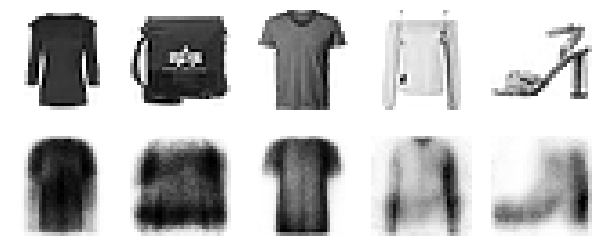

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## 합성곱 오토인코더

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [26]:
conv_encoder = keras.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2)
    ]
)
conv_decoder = keras.Sequential(
    [
        keras.layers.Conv2DTranspose(32, 3, 2, activation='selu', input_shape=[3, 3, 64]),
        keras.layers.Conv2DTranspose(16, 3, 2, 'same', activation='selu'),
        keras.layers.Conv2DTranspose(1, 3, 2, 'same', activation='sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae = keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
history = conv_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 31s 8ms/step - loss: 0.2998 - rounded_accuracy: 0.9207 - val_loss: 0.2786 - val_rounded_accuracy: 0.9395


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 177ms/step


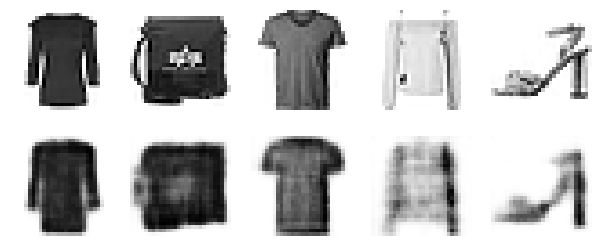

In [28]:
show_reconstructions(conv_ae)
plt.show()

## 순환 오토인코더

In [29]:
recurrent_encoder = keras.Sequential(
    [keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]), keras.layers.LSTM(30)]
)
recurrent_decoder = keras.Sequential(
    [
        keras.layers.RepeatVector(28, input_shape=[30]),
        keras.layers.LSTM(100, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(28, 'sigmoid'))
    ]
)
recurrent_ae = keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(keras.optimizers.experimental.SGD(.1), 'binary_crossentropy', [rounded_accuracy])

In [30]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = recurrent_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 41s 19ms/step - loss: 0.5180 - rounded_accuracy: 0.7548 - val_loss: 0.4527 - val_rounded_accuracy: 0.8189


1/1 [==============================] - 1s 893ms/step


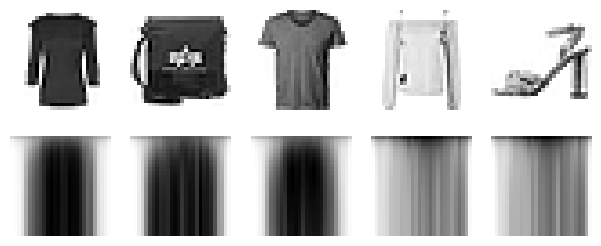

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

## 잡음 제거 오토인코더

가우시안 잡음을 사용한다:

In [32]:
denoising_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(.2),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
denoising_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(keras.optimizers.experimental.SGD(1), 'binary_crossentropy', [rounded_accuracy])
# history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = denoising_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 10s 6ms/step - loss: 0.3461 - rounded_accuracy: 0.8801 - val_loss: 0.3172 - val_rounded_accuracy: 0.9073


1/1 [==============================] - 0s 73ms/step


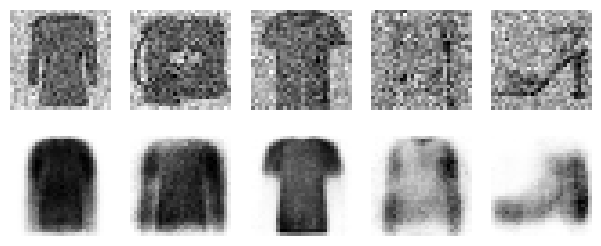

In [33]:
noise = keras.layers.GaussianNoise(.2)
show_reconstructions(denoising_ae, noise(X_valid, True))
plt.show()

드롭아웃을 사용한다:

In [34]:
dropout_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(.5),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
dropout_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = dropout_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.3565 - rounded_accuracy: 0.8708 - val_loss: 0.3213 - val_rounded_accuracy: 0.9047


1/1 [==============================] - 0s 66ms/step
그림 저장 dropout_denoising_plot


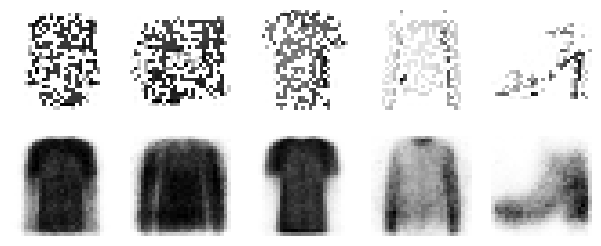

In [35]:
dropout = keras.layers.Dropout(.5)
show_reconstructions(dropout_ae, dropout(X_valid, True))
save_fig('dropout_denoising_plot', False)

## 희소 오토인코더

간단한 적층 오토인코더를 만들어 희소 오토인코더와 비교한다. 이번에는 코딩 층에 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록 만든다:

In [36]:
simple_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'sigmoid')]
)
simple_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
simple_ae = keras.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = simple_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.4346 - rounded_accuracy: 0.7955 - val_loss: 0.3772 - val_rounded_accuracy: 0.8501


1/1 [==============================] - 0s 72ms/step


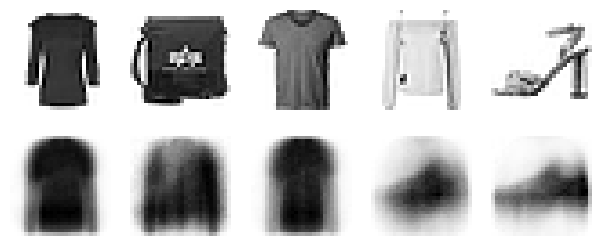

In [37]:
show_reconstructions(simple_ae)
plt.show()

활성화 히스토그램을 출력하기 위한 함수를 만든다:

In [38]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), widths * .8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: f'{int(np.around(100 * y))}%'))
    ax.grid(True)

In [39]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)
    fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label=f'Overall Mean = {mean:.2f}')
    ax1.legend(loc='upper center', fontsize=14)
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neuron Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

이 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력한다. 왼쪽의 히스토그램은 전체 활성화의 분포이다. 0과 1에 가까운 값이 전체적으로 더 많다. 이는 시그모이드 함수가 포화되는 특성 때문이다. 오른쪽의 히스토그램은 평균 뉴런의 분포이다. 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가진다. 두 히스토그램은 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보인다. 하지만 일부 뉴런은 거의 항상 활성화된다(오른쪽 히스토그램의 오른쪽편).

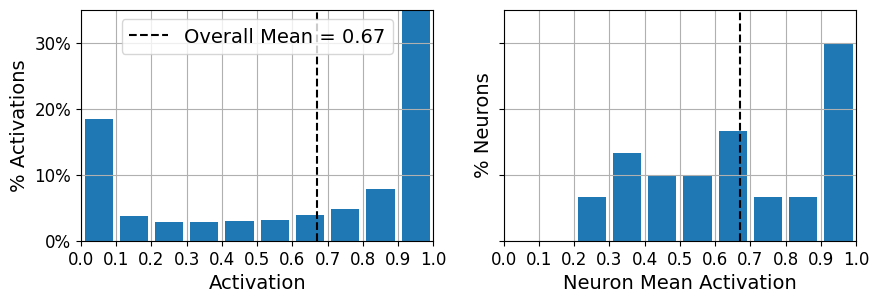

In [40]:
plot_activations_histogram(simple_encoder, .35)
plt.show()

코딩 층에 $\ell_1$ 규제를 추가한다:

In [41]:
sparse_l1_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid'),
        keras.layers.ActivityRegularization(1e-3)  # 또는 이전 레이어에 activity_regularizer=keras.regularizers.L1(1e-3)을 추가
    ]
)
sparse_l1_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_l1_ae = keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_l1_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 9s 5ms/step - loss: 0.4314 - rounded_accuracy: 0.8151 - val_loss: 0.3800 - val_rounded_accuracy: 0.8595


1/1 [==============================] - 0s 75ms/step


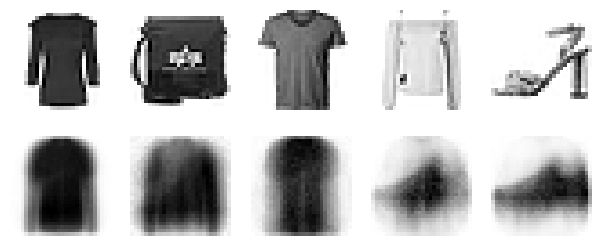

In [42]:
show_reconstructions(sparse_l1_ae)

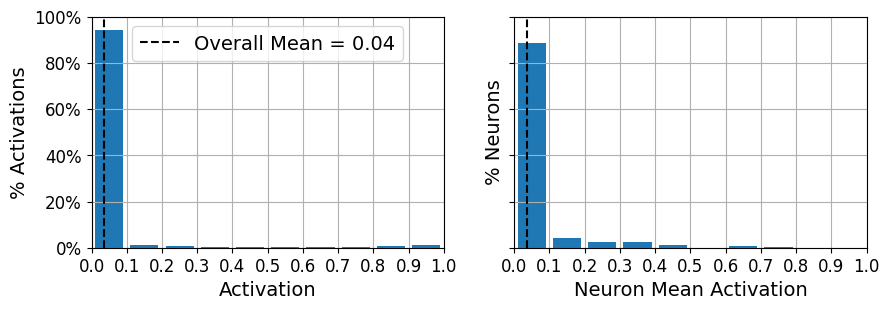

In [43]:
plot_activations_histogram(sparse_l1_encoder, 1.)
plt.show()

희소성을 위해 KL 발산을 사용하여 0%가 아니라 10% 희소성을 만든다:

그림 저장 sparsity_loss_plot


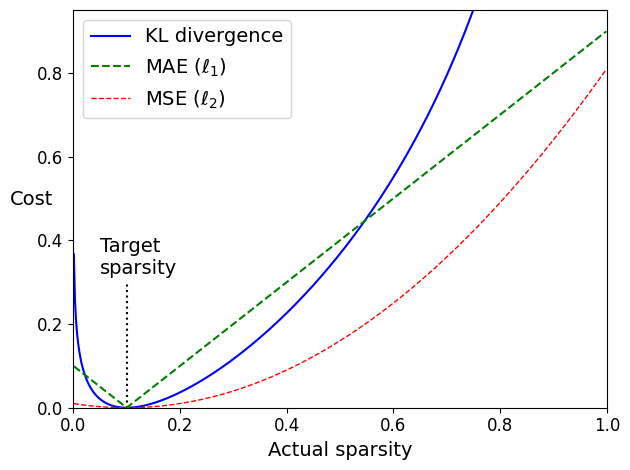

In [44]:
p = .1
q = np.linspace(.001, .999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.absolute(p - q)
plt.plot([p, p], [0, .3], 'k:')
plt.text(.05, .32, 'Target\nsparsity', fontsize=14)
plt.plot(q, kl_div, 'b-', label='KL divergence')
plt.plot(q, mae, 'g--', label=r'MAE ($\ell_1$)')
plt.plot(q, mse, 'r--', linewidth=1, label=r'MSE ($\ell_2$)')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Actual sparsity')
plt.ylabel('Cost', rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig('sparsity_loss_plot')

In [45]:
kl_divergence = keras.metrics.kl_divergence


class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.math.reduce_mean(inputs, 0)
        return self.weight * (
                kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [46]:
kld_reg = KLDivergenceRegularizer(.05)
sparse_kl_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(300, 'sigmoid', activity_regularizer=kld_reg)
    ]
)
sparse_kl_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[300]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
sparse_kl_ae = keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(keras.optimizers.experimental.SGD(1.), 'binary_crossentropy', [rounded_accuracy])
# history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = sparse_kl_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 13s 7ms/step - loss: 0.4143 - rounded_accuracy: 0.8131 - val_loss: 0.3709 - val_rounded_accuracy: 0.8568


1/1 [==============================] - 0s 103ms/step


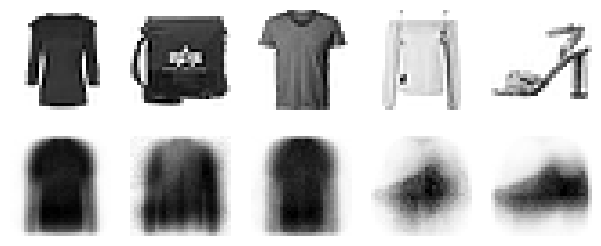

In [47]:
show_reconstructions(sparse_kl_ae)

그림 저장 sparse_autoencoder_plot


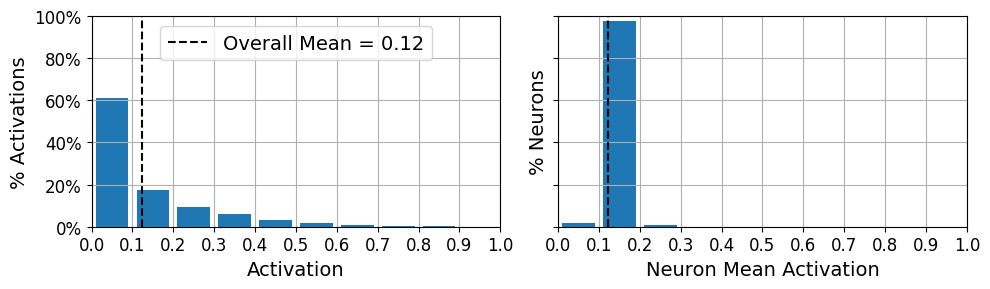

In [48]:
plot_activations_histogram(sparse_kl_encoder)
save_fig('sparse_autoencoder_plot')
plt.show()

## 변이형 오토인코더

In [49]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean

In [50]:
codings_size = 10
inputs = keras.Input([28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, 'selu')(z)
z = keras.layers.Dense(100, 'selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
decoder_inputs = keras.Input([codings_size])
x = keras.layers.Dense(100, 'selu')(decoder_inputs)
x = keras.layers.Dense(150, 'selu')(x)
x = keras.layers.Dense(28 * 28, 'sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean), -1
)
variational_ae.add_loss(tf.math.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', metrics=[rounded_accuracy])
# history = variational_ae.fit(X_train, X_train, 128, 25, validation_data=(X_valid, X_valid))
history = variational_ae.fit(X_train, X_train, 128, validation_data=(X_valid, X_valid))

430/430 [==============================] - 5s 10ms/step - loss: 0.3870 - rounded_accuracy: 0.8632 - val_loss: 0.3535 - val_rounded_accuracy: 0.8891


1/1 [==============================] - 0s 125ms/step


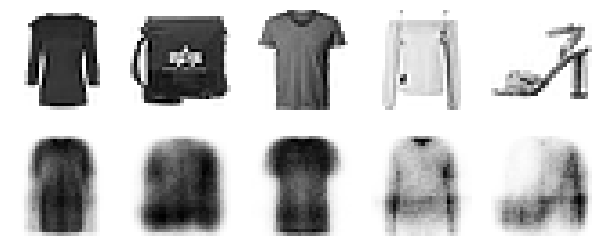

In [51]:
show_reconstructions(variational_ae)
plt.show()

### 패션 MNIST 이미지 생성하기

In [52]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, -1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, 'binary')
        plt.axis('off')

몇 개의 랜덤한 코딩을 생성하고 이를 디코딩하여 결과 이미지를 출력한다:

그림 저장 vae_generated_images_plot


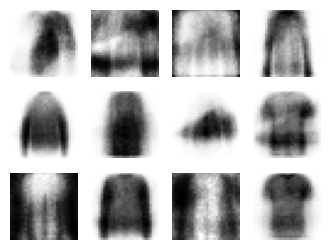

In [53]:
codings = tf.random.normal([12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig('vae_generated_images_plot', False)

이미지 사이에서 의미 보간을 수행한다:

그림 저장 semantic_interpolation_plot


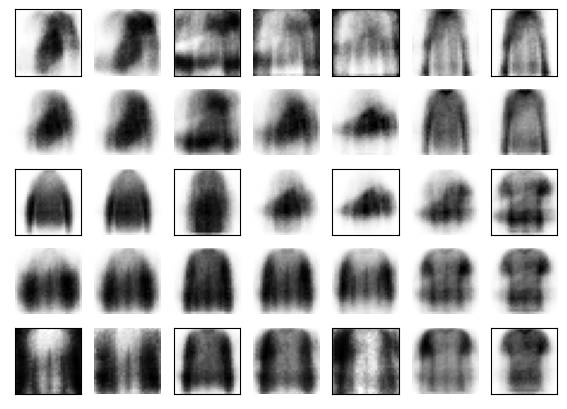

In [54]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, [5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index % 7 % 2 == 0 and index // 7 % 2 == 0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis('off')
    plt.imshow(image, 'binary')
save_fig('semantic_interpolation_plot', False)

## 생성적 적대 신경망

In [55]:
codings_size = 30
generator = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[codings_size]),
        keras.layers.Dense(150, 'selu'),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
discriminator = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(150, 'selu'),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(1, 'sigmoid')
    ]
)
gan = keras.Sequential([generator, discriminator])

In [56]:
discriminator.compile(loss='binary_crossentropy')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy')

In [57]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, True).prefetch(tf.data.AUTOTUNE)

In [58]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        for X_batch in dataset:
            # 단계 1 - 판별자 훈련
            noise = tf.random.normal([batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # 단계 2 - 생성자 훈련
            noise = tf.random.normal([batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch 1/1


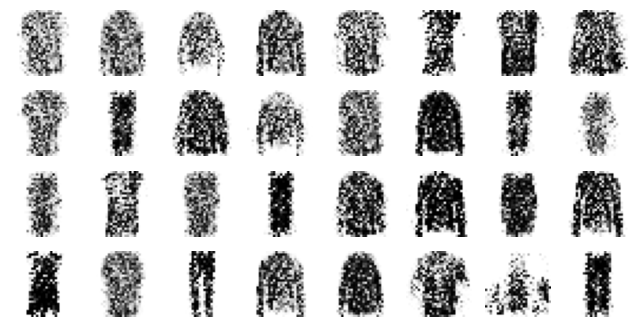

In [59]:
train_gan(gan, dataset, batch_size, codings_size, 1)

그림 저장 gan_generated_images_plot


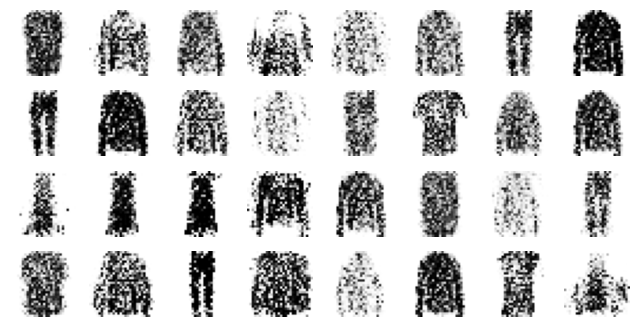

In [60]:
noise = tf.random.normal([batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig('gan_generated_images_plot', False)

Epoch 1/1


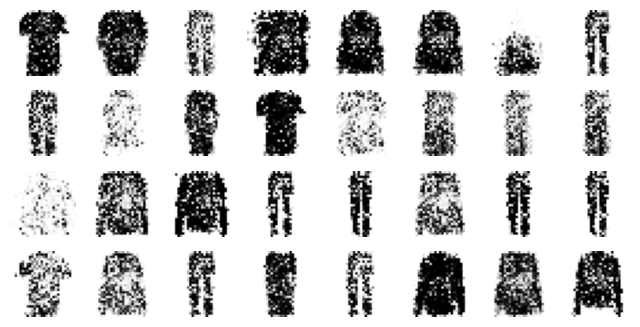

In [61]:
# train_gan(gan, dataset, batch_size, codings_size)
train_gan(gan, dataset, batch_size, codings_size, 1)

### 심층 합성곱 GAN

In [62]:
codings_size = 100
generator = keras.Sequential(
    [
        keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
        keras.layers.Reshape([7, 7, 128]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(64, 5, 2, 'same', activation='selu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(1, 5, 2, 'same', activation='tanh')
    ]
)
discriminator = keras.Sequential(
    [
        keras.layers.Conv2D(64, 5, 2, 'same', activation=keras.layers.LeakyReLU(.2), input_shape=[28, 28, 1]),
        keras.layers.Dropout(.4),
        keras.layers.Conv2D(128, 5, 2, 'same', activation=keras.layers.LeakyReLU(.2)),
        keras.layers.Dropout(.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, 'sigmoid')
    ]
)
gan = keras.Sequential([generator, discriminator])

In [63]:
discriminator.compile(loss='binary_crossentropy')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy')

In [64]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.  # 크기 변경과 스케일 조정

In [65]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, True).prefetch(tf.data.AUTOTUNE)

Epoch 1/1


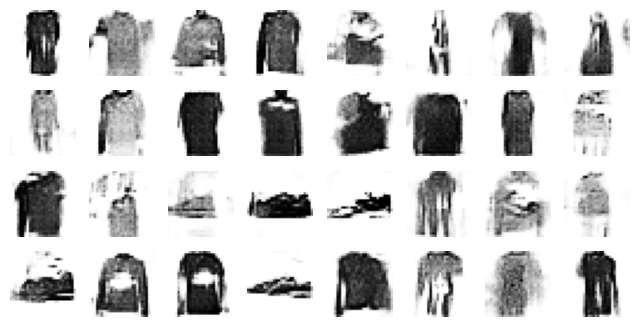

In [66]:
# train_gan(gan, dataset, batch_size, codings_size)
train_gan(gan, dataset, batch_size, codings_size, 1)

그림 저장 dcgan_generated_images_plot


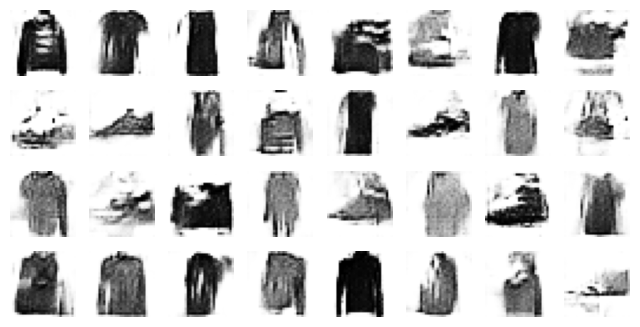

In [67]:
noise = tf.random.normal([batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig('dcgan_generated_images_plot', False)

## 추가 자료

### 이진 오토인코더를 사용한 해싱

패션 MNIST 데이터셋을 다시 로드한다:

In [83]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

인코더의 출력 층이 시그모이드 활성화 함수와 16개의 뉴런을 가지고 있고 가우시안 잡음이 그 앞에 놓인 오토인코더를 훈련한다. 훈련하는 동안 잡음 층이 이전 층이 큰 값을 출력하도록 학습시킨다. 작은 값은 잡음에 묻히기 때문이다. 결국 시그모이드 활성화 함수 덕분에 출력 층은 0~1 사이의 값을 출력한다. 출력 값을 0과 1로 반올림하면 16비트 "시맨틱" 해시를 얻는다. 모든 것이 잘 수행되면 비슷한 이미지는 같은 해시를 가지게 된다. 이는 검색 엔진에 매우 유용하다. 예를 들어, 이미지의 시맨틱 해시에 따라 서버에 이미지를 저장하면 같은 서버에는 모두 비슷한 이미지가 저장된다. 검색 엔진 사용자가 탐색할 이미지를 전달하면, 검색 엔진이 인코더를 사용해 이 이미지의 해시를 계산하고, 이 해시에 해당하는 서버의 모든 이미지를 빠르게 반환할 수 있다.

In [87]:
hashing_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, 'selu'),
        keras.layers.GaussianNoise(15.),
        keras.layers.Dense(16, 'sigmoid')
    ]
)
hashing_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[16]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
hashing_ae = keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(keras.optimizers.experimental.Nadam(jit_compile=False), 'binary_crossentropy', [rounded_accuracy])
# history = hashing_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = hashing_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.4086 - rounded_accuracy: 0.8127 - val_loss: 0.3866 - val_rounded_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3698 - rounded_accuracy: 0.8475 - val_loss: 0.3672 - val_rounded_accuracy: 0.8437
Epoch 3/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3590 - rounded_accuracy: 0.8574 - val_loss: 0.3580 - val_rounded_accuracy: 0.8585
Epoch 4/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3537 - rounded_accuracy: 0.8629 - val_loss: 0.3550 - val_rounded_accuracy: 0.8620
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3502 - rounded_accuracy: 0.8667 - val_loss: 0.3470 - val_rounded_accuracy: 0.8748
Epoch 6/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3475 - rounded_accuracy: 0.8691 - val_loss: 0.3442 - val_rounded_accuracy: 0.8764
Epoch 7/10
1719/1719 [======

오토인코더는 정보를 매우 크게 (16비트로!) 압축하기 때문에 손실이 많지만 이미지를 재구성하려는 것이 아니라 시맨틱 해시를 생성하는 것이 목적이므로 괜찮다:

1/1 [==============================] - 0s 77ms/step


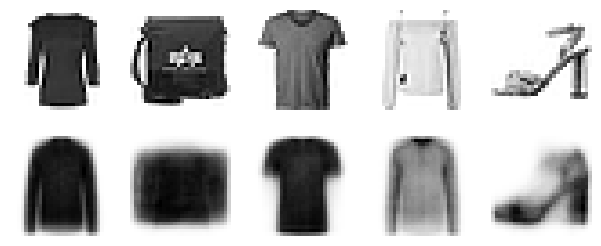

In [88]:
show_reconstructions(hashing_ae)
plt.show()

출력은 0과 1에 매우 가깝다(왼쪽 그래프):

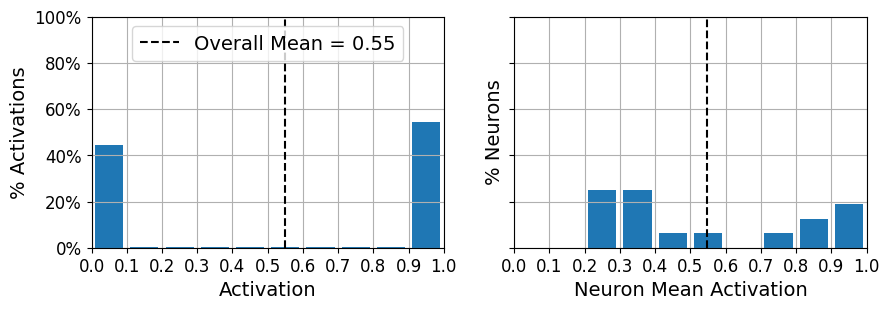

In [89]:
plot_activations_histogram(hashing_encoder)
plt.show()

검증 세트에 있는 처음 몇 개의 이미지에 대한 해시를 확인한다:

In [105]:
hashes = np.around(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(1)
for h in hashes[:5]:
    print(f'{h:016b}')
print('...')

157/157 [==============================] - 0s 1ms/step
1111111000000001
1110101000100001
1110111000000011
1111011000000100
0110001000110000
...


이제 검증 세트에 있는 이미지 중 가장 많이 등장하는 해시를 찾는다. 해시마다 몇 개의 샘플을 출력한다. 다음 이미지에서 한 행에 있는 이미지는 모두 같은 해시를 가진다:

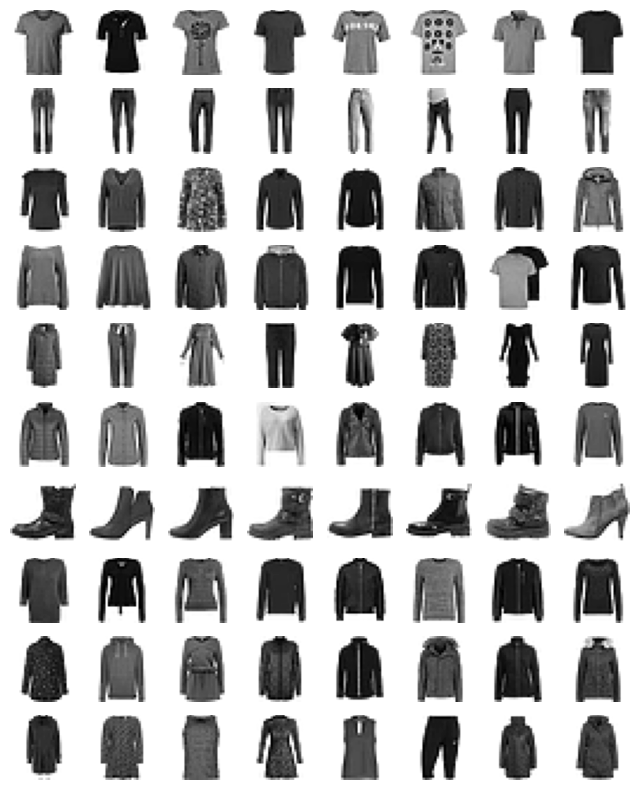

In [113]:
from collections import Counter

n_hashes = 10
n_images = 8
top_hashes = Counter(hashes).most_common(n_hashes)
plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, 'binary')
        plt.axis('off')

## 연습

1. _잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련한다. CIFAR10 이미지 데이터셋을 사용한다. 다음 단계를 따른다._
* 데이터셋을 훈련 세트와 테스트 세트로 나눈다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련한다.
* 이미지가 잘 재구성되는지 확인한다. 코딩 층의 각 뉴런을 가장 크게 활성화하는 이미지를 시각화한다.
* 이 오토인코더의 아래 층을 재사용해 분류 DNN을 만든다. 훈련 세트에서 이미지 500개만 사용해 훈련한다. 사전훈련을 사용하는 것이 더 나을까? 사용하지 않는 것이 더 나을까?

In [70]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [71]:
denoising_encoder = keras.Sequential(
    [
        keras.layers.GaussianNoise(.1, input_shape=[32, 32, 3]),
        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
    ]
)

In [72]:
denoising_encoder.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_42 (Dense)            (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
N

In [73]:
denoising_decoder = keras.Sequential(
    [
        keras.layers.Dense(16 * 16 * 32, activation='relu', input_shape=[512]),
        keras.layers.Reshape([16, 16, 32]),
        keras.layers.Conv2DTranspose(3, 3, 2, 'same', activation='sigmoid')
    ]
)

In [74]:
denoising_decoder.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 8192)              4202496   
                                                                 
 reshape_12 (Reshape)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 3)        867       
 ranspose)                                                       
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [75]:
denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(keras.optimizers.experimental.Nadam(jit_compile=False), 'binary_crossentropy', ['mse'])
# history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))
history = denoising_ae.fit(X_train, X_train, validation_data=(X_test, X_test))

1563/1563 [==============================] - 31s 19ms/step - loss: 0.5834 - mse: 0.0144 - val_loss: 0.6163 - val_mse: 0.0249


1/1 [==============================] - 0s 100ms/step


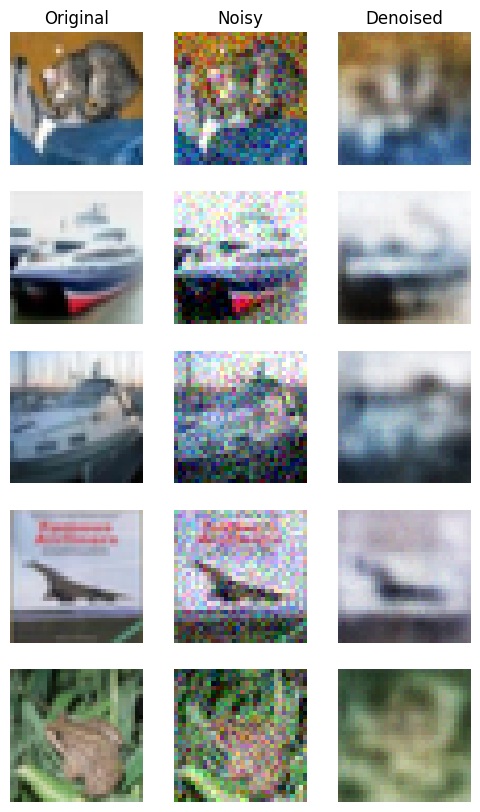

In [76]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * .1
new_images_denoised = denoising_ae.predict(new_images_noisy)
plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title('Original')
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title('Noisy')
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title('Denoised')
plt.show()

2. _이미지 데이터셋을 하나 선택해 변이형 오토인코더를 훈련하고 이미지를 생성해보세요. 또는 관심있는 레이블이 없는 데이터셋을 찾아서 새로운 샘플을 생성할 수 있는지 확인해 보세요._